In [33]:
# import libraries
try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly
except Exception:
  pass
import tensorflow as tf
import pandas as pd
from tensorflow import keras
!pip install tensorflow-datasets
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding,Bidirectional, Dropout


print(tf.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2.12.0-dev20230114


In [34]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

--2023-01-14 13:18:03--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 104.26.2.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv.1’

train-data.tsv.1    100%[===================>] 349.84K  --.-KB/s    in 0.005s  

2023-01-14 13:18:04 (67.2 MB/s) - ‘train-data.tsv.1’ saved [358233/358233]

--2023-01-14 13:18:04--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 104.26.2.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv.1’

valid-data.tsv.1    100%[========

In [35]:
train_dataset = pd.read_csv(train_file_path, delimiter='\t',header=None, names=["label", "message"])
test_dataset = pd.read_csv(test_file_path, delimiter='\t',header=None, names=["label", "message"])

In [36]:
train_dataset.head()

,label,message
0,ham,ahhhh...just woken up!had a bad dream about u ...
1,ham,you can never do nothing
2,ham,"now u sound like manky scouse boy steve,like! ..."
3,ham,mum say we wan to go then go... then she can s...
4,ham,never y lei... i v lazy... got wat? dat day ü ...


In [37]:
train_dataset.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      3619   3430                             sorry, i'll call later   22
spam      560    505  hmv bonus special 500 pounds of genuine hmv vo...    3

In [38]:
test_dataset.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      1205   1173                             sorry, i'll call later    8
spam      187    176  you have won a nokia 7250i. this is what you g...    2

In [39]:
train_dataset['text_length'] = train_dataset['message'].apply(len)
train_dataset['msg_type'] = train_dataset['label'].map({'ham':0, 'spam':1})
train_label = train_dataset['msg_type'].values

test_dataset['text_length'] = test_dataset['message'].apply(len)
test_dataset['msg_type'] = test_dataset['label'].map({'ham':0, 'spam':1})
test_label = test_dataset['msg_type'].values

In [40]:
# Defining pre-processing parameters
max_len = 50 
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # out of vocabulary token
vocab_size = 500
# tokenize into word character (word level)
# num_words for maximum number of unique tokens
# filter out the punctuation terms
# convert all words to lower case
# convert all words to integer index
tokenizer = Tokenizer(num_words = vocab_size, 
                      char_level = False,
                      oov_token = oov_tok)
tokenizer.fit_on_texts(train_dataset['message'])

In [41]:
training_sequences = tokenizer.texts_to_sequences(train_dataset['message'])
training_padded = pad_sequences(training_sequences,
                                maxlen = max_len,
                                padding = padding_type,
                                truncating = trunc_type)
testing_sequences = tokenizer.texts_to_sequences(test_dataset['message'])
testing_padded = pad_sequences(testing_sequences,
                               maxlen = max_len,
                               padding = padding_type,
                               truncating = trunc_type)

In [42]:
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (4179, 50)
Shape of testing tensor:  (1392, 50)


In [43]:
vocab_size = 1000 
embedding_dim = 16
drop_value = 0.2
n_dense = 24
n_lstm =128
drop_lstm = 0.2

model2 = Sequential()
model2.add(Embedding(vocab_size,
                     embedding_dim,
                     input_length = max_len))
model2.add(Bidirectional(LSTM(n_lstm, return_sequences = False)))
model2.add(Dropout(drop_lstm))
model2.add(Dense(1, activation='sigmoid'))
model2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 50, 16)            16000     
                                                                 
 bidirectional_7 (Bidirectio  (None, 256)              148480    
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 164,737
Trainable params: 164,737
Non-trainable params: 0
_________________________________________________________________


In [44]:
model2.compile(loss = 'binary_crossentropy',
               optimizer = 'adam',
               metrics=['accuracy'])
num_epochs = 30
early_stop = EarlyStopping(monitor = 'val_loss',
                           patience = 2)
history = model2.fit(training_padded,
                     train_label,
                     epochs = num_epochs,
                     validation_data = (testing_padded, test_label),
                     callbacks = [early_stop])

Epoch 1/30
131/131 [==============================] - 41s 278ms/step - loss: 0.2234 - accuracy: 0.9153 - val_loss: 0.0991 - val_accuracy: 0.9698
Epoch 2/30
131/131 [==============================] - 18s 138ms/step - loss: 0.0728 - accuracy: 0.9785 - val_loss: 0.0785 - val_accuracy: 0.9770
Epoch 3/30
131/131 [==============================] - 17s 130ms/step - loss: 0.0575 - accuracy: 0.9832 - val_loss: 0.0741 - val_accuracy: 0.9784
Epoch 4/30
131/131 [==============================] - 18s 139ms/step - loss: 0.0538 - accuracy: 0.9823 - val_loss: 0.0723 - val_accuracy: 0.9727
Epoch 5/30
131/131 [==============================] - 18s 138ms/step - loss: 0.0517 - accuracy: 0.9868 - val_loss: 0.0820 - val_accuracy: 0.9806
Epoch 6/30
131/131 [==============================] - 18s 138ms/step - loss: 0.0359 - accuracy: 0.9902 - val_loss: 0.0651 - val_accuracy: 0.9820
Epoch 7/30
131/131 [==============================] - 19s 147ms/step - loss: 0.0338 - accuracy: 0.9902 - val_loss: 0.0654 - val_ac

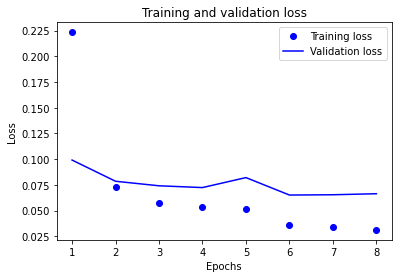

In [45]:
history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [46]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
  sequences = tokenizer.texts_to_sequences([pred_text])
  padded_text = pad_sequences(sequences,
                                maxlen = max_len,
                                padding = padding_type,
                                truncating = trunc_type)

  prediction=model2.predict(padded_text)
  if(prediction<.5):
    prediction = "ham"
  else:
    prediction = "spam"

  return (pred_text,prediction)

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

1/1 [==============================] - 1s 903ms/step
('how are you doing today?', 'ham')


In [47]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


1/1 [==============================] - 0s 37ms/step
You passed the challenge. Great job!
